In [49]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
from functools import partial
from aesthetics.plotting import adjust_spines
from tqdm import tqdm

# imports from tensorflow/models/tutorial/image/imagenet/classify_image.py
import argparse
import os.path
import re
import sys
import tarfile
from six.moves import urllib

# from deepdream notebook http://nbviewer.jupyter.org/github/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb
from IPython.display import clear_output, Image, display, HTML

%matplotlib inline

plt.style.use('deepretina')

/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Load VGG weights

In [52]:
vgg_weight_path = os.path.expanduser('~/data/vgg16-model/vgg16_weights.h5')
f = h5py.File(vgg_weight_path, 'r')

In [53]:
layer_names = []
layer_id = []
for layer in sorted(list(f.keys())):
    layer_names.append(layer)
    layer_id.append(int(layer.split('_')[-1]))
sorted_layer_names = np.array(layer_names)[np.argsort(layer_id)]

In [54]:
for layer in sorted_layer_names:
    if list(f[layer].keys()):
        print('%s : (%s, %s)' %(layer, *list(f[layer].keys())))
    else:
        print(layer)

layer_0
layer_1 : (param_0, param_1)
layer_2
layer_3 : (param_0, param_1)
layer_4
layer_5
layer_6 : (param_0, param_1)
layer_7
layer_8 : (param_0, param_1)
layer_9
layer_10
layer_11 : (param_0, param_1)
layer_12
layer_13 : (param_0, param_1)
layer_14
layer_15 : (param_0, param_1)
layer_16
layer_17
layer_18 : (param_0, param_1)
layer_19
layer_20 : (param_0, param_1)
layer_21
layer_22 : (param_0, param_1)
layer_23
layer_24
layer_25 : (param_0, param_1)
layer_26
layer_27 : (param_0, param_1)
layer_28
layer_29 : (param_0, param_1)
layer_30
layer_31
layer_32 : (param_0, param_1)
layer_33
layer_34 : (param_0, param_1)
layer_35
layer_36 : (param_0, param_1)


In [55]:
np.array(f['layer_3/param_0']).shape

(64, 64, 3, 3)

In [255]:
ground_W3 = np.array(f['layer_3/param_0']).copy()

In [256]:
blah = np.rollaxis(ground_W3, 0, 4)
blah = np.rollaxis(blah, 0, 3)
blah.shape

(3, 3, 64, 64)

In [257]:
ground_W1 = np.array(f['layer_1/param_0']).copy()
ground_W1.shape

(64, 3, 3, 3)

In [258]:
blah = np.rollaxis(ground_W1, 0, 4)
blah = np.rollaxis(blah, 0, 3)
blah.shape

(3, 3, 3, 64)

In [320]:
tf.reset_default_graph()

In [321]:
height, width = (20,20)
with tf.variable_scope('input'):
    # Given an input tensor of shape `[batch, in_height, in_width, in_channels]`
    X = tf.get_variable("X", shape=(1,height,width,3), dtype=tf.float32, initializer=tf.random_normal_initializer())

# model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
# model.add(Convolution2D(64, 3, 3, activation='relu'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Convolution2D(64, 3, 3, activation='relu'))
# model.add(MaxPooling2D((2,2), strides=(2,2)))    
# filter shape `[filter_height, filter_width, in_channels, out_channels]`
W1 = np.array(f['layer_1/param_0']).copy()
W1 = np.rollaxis(W1, 0, 4)
W1 = np.rollaxis(W1, 0, 3)
W1x = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding='SAME', use_cudnn_on_gpu=True)
relu_W1x = tf.nn.relu(W1x + np.array(f['layer_1/param_1']))
W3 = np.array(f['layer_3/param_0']).copy()
W3 = np.rollaxis(W3, 0, 4)
W3 = np.rollaxis(W3, 0, 3)
# W3 = np.rollaxis(W3)
W3x = tf.nn.conv2d(relu_W1x, W3, strides=[1,1,1,1], padding='SAME', use_cudnn_on_gpu=True)
relu_W3x = tf.nn.relu(W3x + np.array(f['layer_3/param_1']))

In [322]:
Wx.shape

TensorShape([Dimension(1), Dimension(20), Dimension(20), Dimension(64)])

In [323]:
selected_unit = 5
l2_reg = 1e-1
# activity = -tf.nn.l2_loss(relu_W3x[0,:,:,selected_unit]) + l2_reg*(tf.nn.l2_loss(X))
desirable_activity = -tf.nn.l2_loss(relu_W3x[0,:,:,selected_unit])
undesirable_activity = -l2_reg*(tf.nn.l2_loss(relu_W3x[0,:,:,:selected_unit]) + tf.nn.l2_loss(relu_W3x[0,:,:,(selected_unit+1):]) + tf.nn.l2_loss(X))

opt = tf.train.AdamOptimizer(learning_rate=10, beta1=0.9, beta2=0.9, epsilon=1e-08)
grads = opt.compute_gradients(desirable_activity - undesirable_activity)
train_op = opt.apply_gradients(grads)
# train_op = opt.minimize(loss)

In [324]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

iterations = 5000

grad_history = []
activation_history = []
regularization_history = []
for it in tqdm(range(iterations)):
    g = sess.run([train_op, grads, desirable_activity, undesirable_activity])
    grad_history.append(g[1])
    activation_history.append(g[2])
    regularization_history.append(g[3])

100%|██████████| 5000/5000 [00:08<00:00, 562.35it/s]


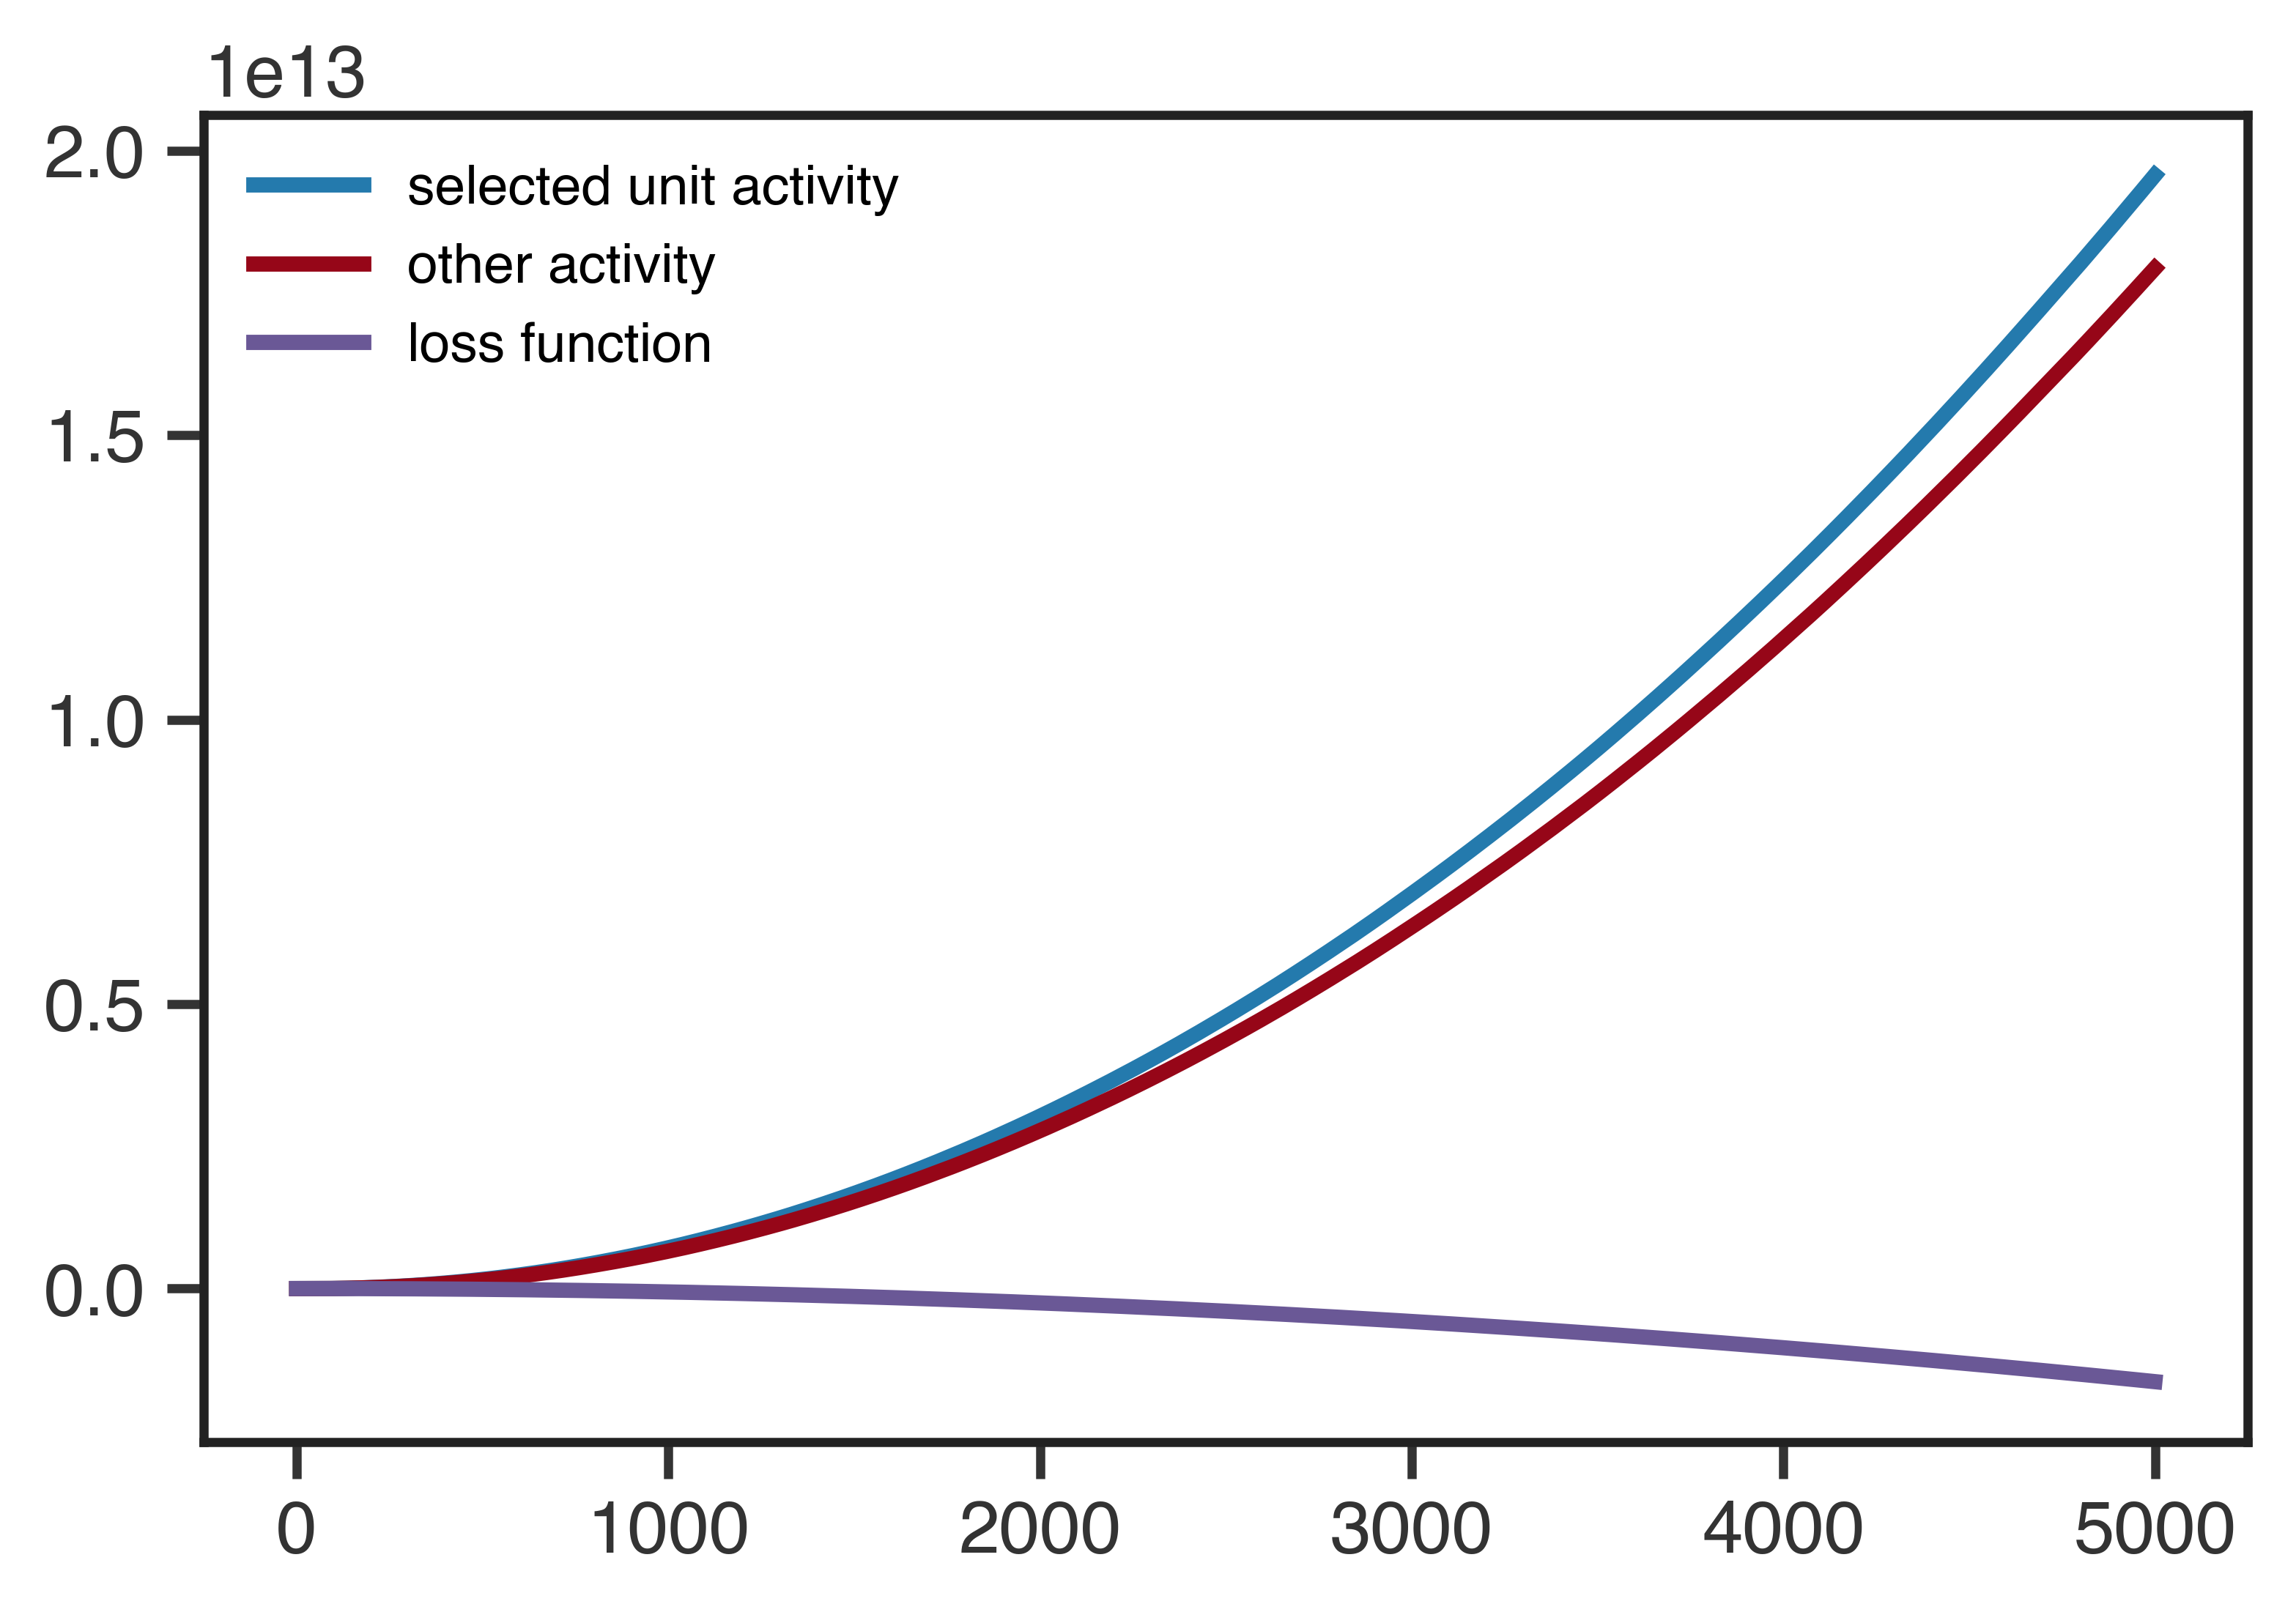

In [330]:
plt.plot(-np.array(activation_history), label='selected unit activity')
plt.plot(-np.array(regularization_history), label='other activity')
plt.plot(np.array(activation_history) - np.array(regularization_history), label='loss function')
plt.legend(loc='upper left', frameon=False, fontsize=9)

In [284]:
maximal_image = sess.run(X)

In [285]:
(np.min(maximal_image[0,:,:,:]), np.max(maximal_image[0,:,:,:]))

(-0.84025031, 0.88748318)

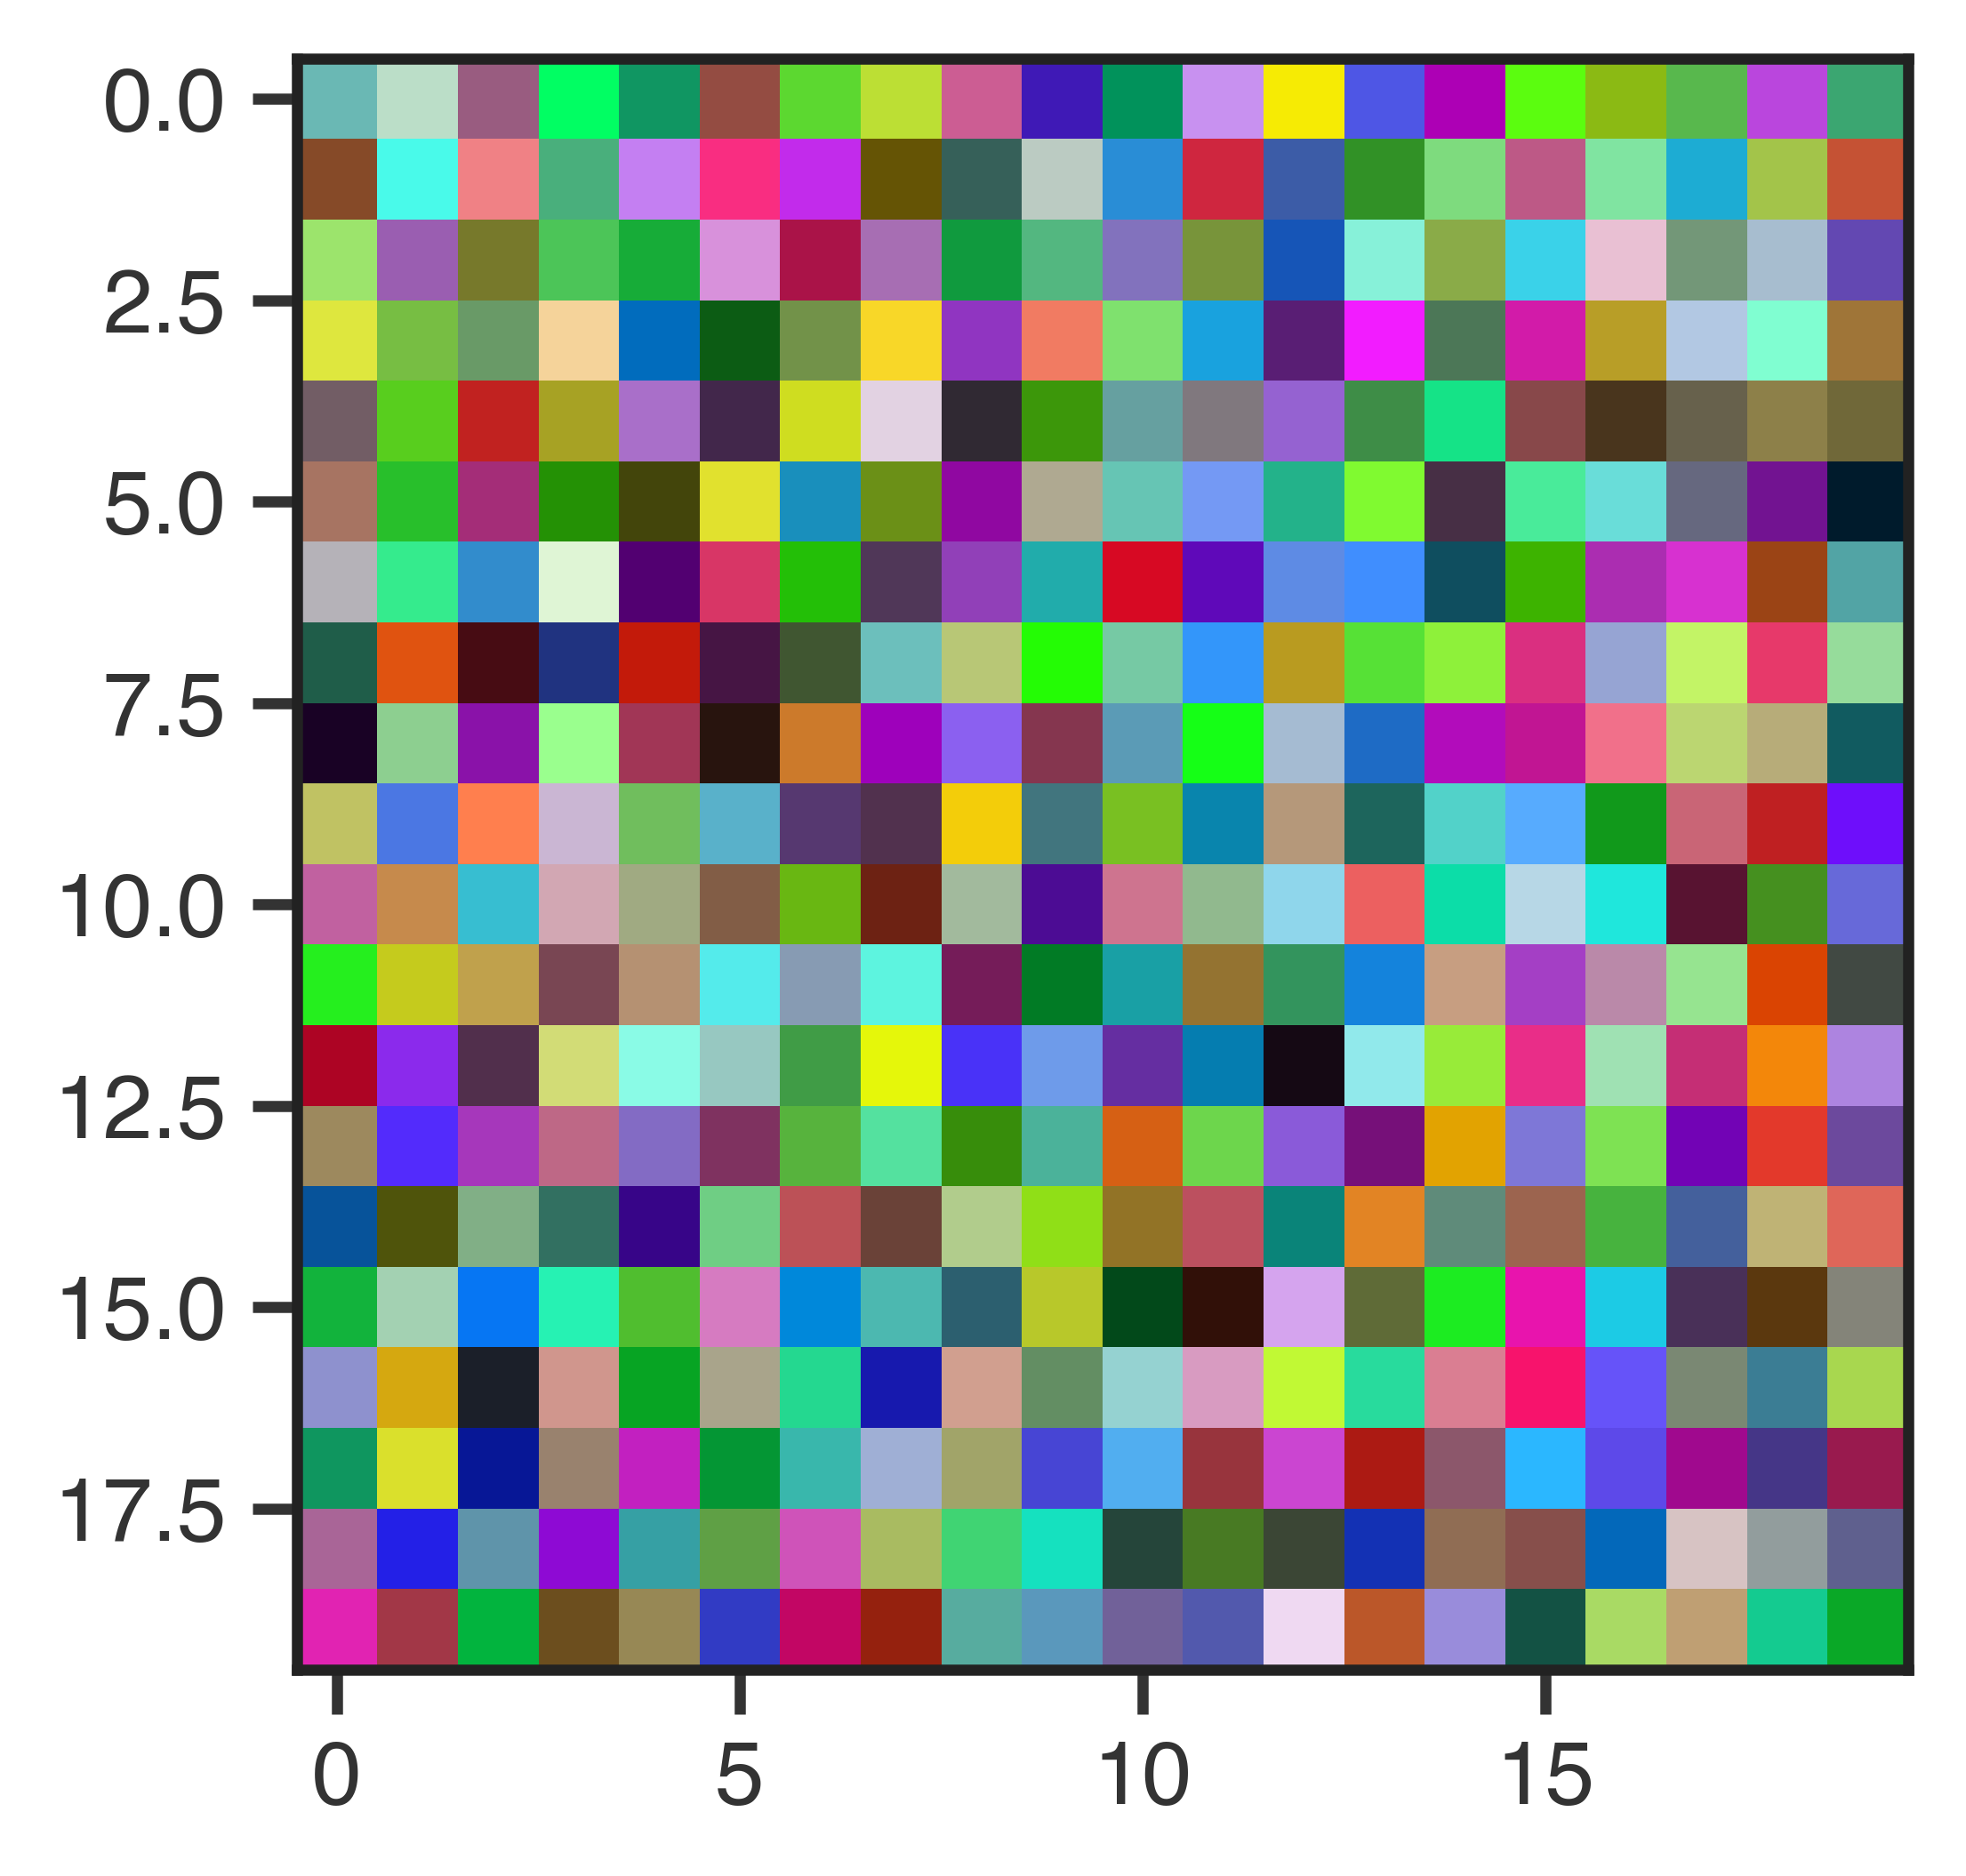

In [286]:
plt.imshow(maximal_image[0,:,:,:])

In [289]:
sess.run(tf.nn.l2_loss(relu_W3x[0,:,:,5]))

1478.6626

In [303]:
relu_W3x.shape

TensorShape([Dimension(1), Dimension(20), Dimension(20), Dimension(64)])

In [308]:
np.arange(64).shape

(64,)

In [315]:
np.arange(10)[:5]

array([0, 1, 2, 3, 4])

In [318]:
np.arange(10)[6:]

array([6, 7, 8, 9])

In [314]:
relu_W3x[0,:,:,selected_unit:]

<tf.Tensor 'strided_slice_18:0' shape=(20, 20, 59) dtype=float32>

In [317]:
selected_unit = 5
unrange = np.where(np.arange(int(relu_W3x.shape[-1])) != 5, True, False).astype('int32')
sess.run(tf.nn.l2_loss(relu_W3x[0,:,:,:selected_unit]) + tf.nn.l2_loss(relu_W3x[0,:,:,(selected_unit+1):]))

119909.88

In [290]:
sess.run(tf.nn.l2_loss(X))

64.19606